# Compare postprocessings

The aim of this notebook is to compare the results of postprocessing perforemd step by step in the notebook with the results of the cumulative postprocessing extracted by the `_fit()` function of the `cryoscope` routine - branch: `test_postprocessing` of `qibocal`

In [1]:
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import scipy 
import scipy.signal
from scipy.optimize import least_squares

from qibocal.protocols.ramsey.utils import fitting
from qibocal.protocols.two_qubit_interaction.cryoscope import (
    CryoscopeParameters,
    CryoscopeResults,
    CryoscopeData,
        residuals,
        exponential_params,
    filter_calc,
    _fit,
    _plot,
)
from pathlib import Path

[Qibo 0.2.12|INFO|2025-01-14 17:57:01]: Loading platform dummy
[Qibo 0.2.12|INFO|2025-01-14 17:57:01]: Loading platform dummy


In [2]:
def load_cryoscope_data(file_path: str, flux_pulse_amplitude: float) -> CryoscopeData:

    cryoscope_data = CryoscopeData(flux_pulse_amplitude=flux_pulse_amplitude)

    data_npz = np.load(file_path)
    D1MX = np.rec.array(data_npz['["D1", "MX"]'])
    D1MY = np.rec.array(data_npz['["D1", "MY"]'])

    data_dict = {("D1", "MX"): D1MX, ("D1", "MY"): D1MY}

    cryoscope_data.data = data_dict

    return cryoscope_data

In [3]:
def fit_no_postprocessing(data: CryoscopeData) -> CryoscopeResults:
    """Postprocessing for cryoscope experiment.

    From <X> and <Y> we compute the expecting step response.
    The complex data <X> + i <Y> are demodulated using the frequency found
    by fitting a sinusoid to both <X> and <Y>.
    Next, the phase is computed and finally the detuning using a savgol_filter.
    The "real" detuning is computed by reintroducing the demodulation frequency.
    Finally, using the parameters given by the flux_amplitude_frequency experiment,
    we compute the expected flux_amplitude by inverting the formula:

    f = c_1 A^2 + c_2 A + c_3

    where f is the detuning and A is the flux amplitude.
    The step response is computed by normalizing the amplitude by its value computed above.
    For some of the manipulations see: https://github.com/DiCarloLab-Delft/PycQED_py3/blob/c4279cbebd97748dc47127e56f6225021f169257/pycqed/analysis/tools/cryoscope_tools.py#L73
    """

    nyquist_order = 0

    fitted_parameters = {}
    detuning = {}
    amplitude = {}
    step_response = {}
    alpha = {}
    time_decay = {}
    feedforward_taps = {}
    feedback_taps = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        t = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(t, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (t[1] - t[0])
        X_exp = 1 - 2 * data[(qubit, "MX")].prob_1
        Y_exp = 1 - 2 * data[(qubit, "MY")].prob_1

        norm_data = X_exp + 1j * Y_exp

        # demodulation frequency found by fitting sinusoidal
        demod_freq = -fitted_parameters[qubit, "MY"][2] / 2 / np.pi * sampling_rate

        # to be used in savgol_filter
        derivative_window_length = 7 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

        # find demodulatation frequency
        demod_data = np.exp(2 * np.pi * 1j * t * demod_freq) * (norm_data)

        # compute phase
        phase = np.unwrap(np.angle(demod_data))

        # compute detuning
        raw_detuning = (
            scipy.signal.savgol_filter(
                phase / (2 * np.pi),
                window_length=derivative_window_size,
                polyorder=2,
                deriv=1,
            )
            * sampling_rate
        )

        # real detuning (reintroducing demod_freq)
        detuning[qubit] = (
            raw_detuning - demod_freq + sampling_rate * nyquist_order
        ).tolist()

        # params from flux_amplitude_frequency_protocol
        params = [1.9412681243469971, -0.012534948170662627, 0.0005454772278201887]
        # params = [  # D2
        #     2.0578,
        #     -0.065,
        #     0.00147,
        # ]

        # invert frequency amplitude formula
        p = np.poly1d(params)
        amplitude[qubit] = [max((p - freq).roots).real for freq in detuning[qubit]]

        # compute step response
        step_response[qubit] = (
            np.array(amplitude[qubit]) / data.flux_pulse_amplitude
        ).tolist()

        return CryoscopeResults(
        amplitude=amplitude,
        detuning=detuning,
        step_response=step_response,
        fitted_parameters=fitted_parameters,
        exp_amplitude=alpha,
        tau=time_decay,
        fir=feedforward_taps,
        iir=feedback_taps,
    )

In [4]:
# import data

data_path = (Path.cwd().parent.parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0")
data_json = data_path / "data.json"
result_path = Path.cwd().parent / "single_IIR_step.pkl"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", flux_pulse_amplitude)


### Local analysis

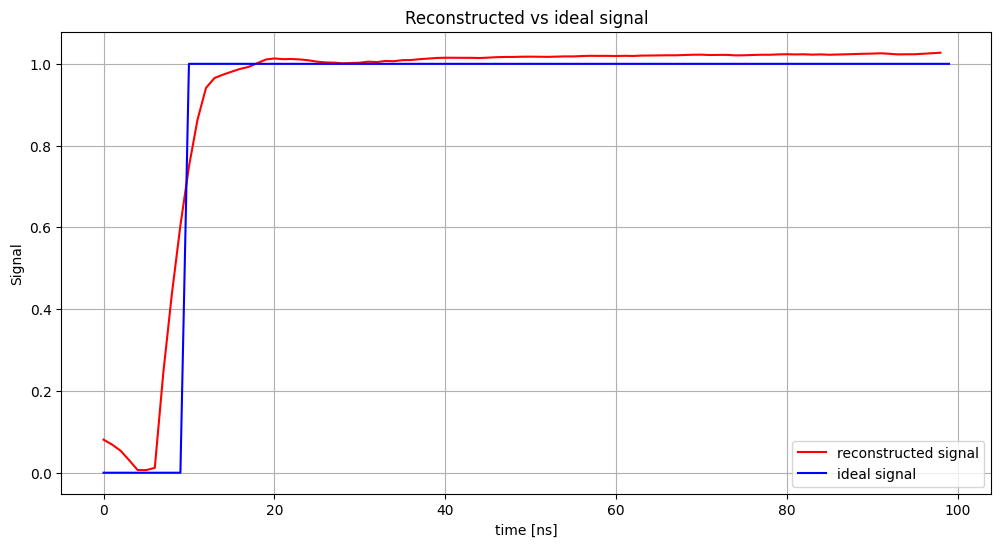

In [5]:
FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(90)])

no_postprocess_step = fit_no_postprocessing(cryoscope_data)

plt.figure(figsize=(12,6))
plt.plot(no_postprocess_step.step_response["D1"], color="red", label="reconstructed signal")
plt.plot(FULL_WAVEFORM, color="blue", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Reconstructed vs ideal signal")
plt.legend()
plt.grid()
plt.show()

In [6]:
cryoscope_data.data["D1","MX"].duration

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [7]:
acquisition_time = len(cryoscope_data.data["D1", "MX"].duration)
print(acquisition_time)

99


In [8]:
params = exponential_params(no_postprocess_step.step_response["D1"], acquisition_time).tolist()

In [9]:
print(params)

[1.0128182543845106, 0.19478485525042055, -0.26135588711242436]


In [10]:
g, tau, exp_amplitude = params
t = np.arange(0, acquisition_time, 1)
START = 10

exp_corrected = no_postprocess_step.step_response["D1"] / (
    g * (1 + exp_amplitude * np.exp(-(t - START) / tau))
)

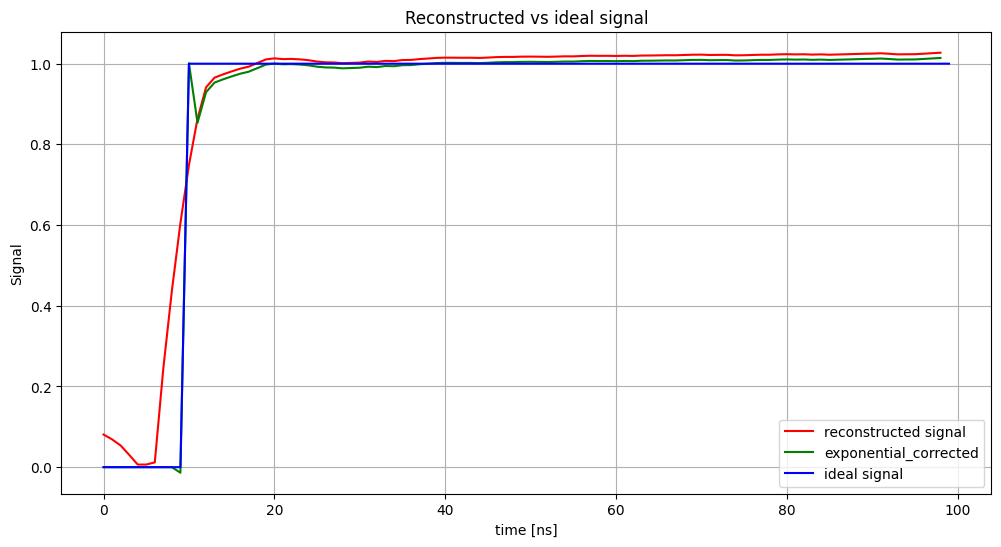

In [11]:
# plot exponential correction
plt.figure(figsize=(12, 6))
plt.plot(
    no_postprocess_step.step_response["D1"], color="red", label="reconstructed signal"
)
plt.plot(exp_corrected, color = "green", label = "exponential_corrected")
plt.plot(FULL_WAVEFORM, color="blue", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Reconstructed vs ideal signal")
plt.legend()
plt.grid()
plt.show()